<h1>Submission for Kaggle Competition without training data.</h1>
<h2>Create test submission files using OTSU mask on black and white images.</h2>

In [13]:
#import packages
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from skimage.filters import threshold_otsu
from scipy import ndimage
import pathlib
import imageio
import numpy as np
import cv2

In [14]:
#set path locations, warnings, and seed
TRAIN_PATH = 'Nuclei/stage1_train/'
TEST_PATH = 'Nuclei/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

In [15]:
#get list of training and testing ids
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]

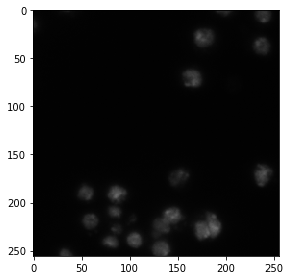

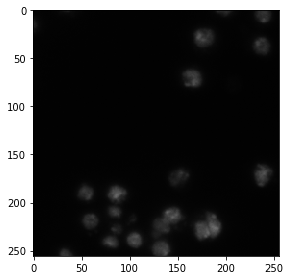

In [16]:
#Compare image and gray image
img = imread(TRAIN_PATH + train_ids[0] + '/images/'+ train_ids[0] + '.png')[:,:,:IMG_CHANNELS]
img_gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

imshow(img)
plt.show()

imshow(img_gray)
plt.show()

Store image id and gray image in a dictionary object to plug into function later on

In [17]:
X_grays = {} #store id and gray image
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    X_grays[id_] = img_gray

print("Keys", list(X_grays.keys()))

100%|██████████████████████████████████████████| 65/65 [00:01<00:00, 56.03it/s]


Keys ['0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5', '0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac', '0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732', '0e132f71c8b4875c3c2dd7a22997468a3e842b46aa9bd47cf7b0e8b7d63f0925', '0ed3555a4bd48046d3b63d8baf03a5aa97e523aa483aaa07459e7afa39fb96c6', '0f1f896d9ae5a04752d3239c690402c022db4d72c0d2c087d73380896f72c466', '1747f62148a919c8feb6d607faeebdf504b5e2ad42b6b1710b1189c37ebcdb2c', '17b9bf4356db24967c4677b8376ac38f826de73a88b93a8d73a8b452e399cdff', '1879f4f4f05e2bada0ffeb46c128b8df7a79b14c84f38c3e216a69653495153b', '191b2b2205f2f5cc9da04702c5d422bc249faf8bca1107af792da63cccfba829', '1962d0c5faf3e85cda80e0578e0cb7aca50826d781620e5c1c4cc586bc69f81a', '1cdbfee1951356e7b0a215073828695fe1ead5f8b1add119b6645d2fdc8d844e', '1d9eacb3161f1e2b45550389ecf7c535c7199c6b44b1c6a46303f7b965e508f1', '1ef68e93964c2d9230100c1347c328f6385a7bc027879dc3d4c055e6fe80cb3c', '259b35151d4a7a5ffdd7ab7f171b142db8cfe40be

0114f484a16c152baa2d82fdd43740880a762c93f436c8988ac461c5c9dbe7d5 with a shape of (256, 256)


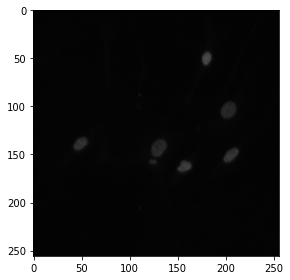

0999dab07b11bc85fb8464fc36c947fbd8b5d6ec49817361cb780659ca805eac with a shape of (519, 253)


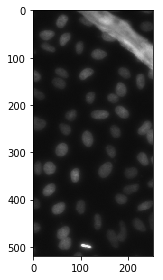

0a849e0eb15faa8a6d7329c3dd66aabe9a294cccb52ed30a90c8ca99092ae732 with a shape of (256, 256)


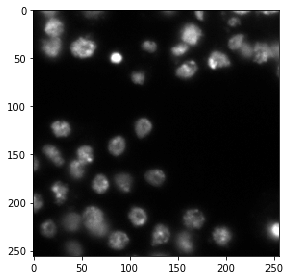

In [18]:
#Confirm dictionary format works
for key in list(X_grays.keys())[:3]:
    print(key + " with a shape of " + str(X_grays[key].shape))
    imshow(X_grays[key])
    plt.show()

Write three functions:
<ol>
    <li>create_mask() to create a mask and return a row for a data frame</li>
    <li> analyze_dict_of_images() to apply create_mask function to every image in testing data</li>
    <li>rle_encoding() to store information in DSB format</li>
</ol>

In [19]:
def create_mask(img, im_id):
    """
    Create mask based on gray image 
    """
    thresh_val = threshold_otsu(img)
    mask = np.where(img > thresh_val, 1, 0)
    if np.sum(mask==0) < np.sum(mask==1):
        mask = np.where(mask, 0, 1)    
        labels, nlabels = ndimage.label(mask)
    labels, nlabels = ndimage.label(mask)
    
    im_df = pd.DataFrame()
    for label_num in range(1, nlabels+1):
        label_mask = np.where(labels == label_num, 1, 0)
        if label_mask.flatten().sum() > 10:
            rle = rle_encoding(label_mask)
            s = pd.Series({'ImageId': im_id, 'EncodedPixels': rle})
            im_df = im_df.append(s, ignore_index=True)
    
    return im_df

def analyze_dict_of_images(img_dict):
    '''
    Takes a list of images, analyzes each,
    and returns a submission-ready DataFrame.'''
    all_df = pd.DataFrame()
    for key in list(img_dict.keys()):
        im_df = create_mask(img=img_dict[key], im_id=key)
        all_df = all_df.append(im_df, ignore_index=True)
    
    return all_df

def rle_encoding(x):
    '''
    x: numpy array of shape (height, width), 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = np.where(x.T.flatten()==1)[0] # .T sets Fortran order down-then-right
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return " ".join([str(i) for i in run_lengths])

In [20]:
df = analyze_dict_of_images(X_grays)

In [21]:
df[['ImageId','EncodedPixels']].head(5)

,ImageId,EncodedPixels
0,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,45104 8 45359 11 45614 13 45869 14 46124 15 46...
1,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,50280 6 50534 10 50789 12 51043 14 51299 14 51...
2,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,10894 3 11147 7 11402 9 11656 11 11911 12 1216...
3,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,31633 4 31886 10 32139 14 32394 15 32649 17 32...
4,0114f484a16c152baa2d82fdd43740880a762c93f436c8...,50843 2 51097 6 51351 8 51606 10 51860 12 5211...


In [23]:
#write submission file
df[['ImageId','EncodedPixels']].to_csv('sub-dsbowl2018-2-nonmodel.csv',index=False)